In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import pandas as pd
import numpy as np
import random
import copy
import collections
import typing
from tqdm import tqdm
from collections import deque

/home/ec2-user/.local/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
torch.cuda.is_available()

False

In [3]:
#environment class
class Environment():
    
    #initialize dataset, a random trajectory, and current cycle
    def __init__(self):
        self.dataset = pd.read_csv('train.csv')
        self.episode = self.get_trajectory(np.random.randint(low=1, high=79, size=1))
        self.cycle = 0
        
    #get random trajectory
    def get_trajectory(self, engine_id):
        return self.dataset[self.dataset.engine_id==engine_id.item()].health_indicator.to_numpy()
    
    #reset environment    
    def reset(self):
        self.cycle = 0
        self.episode = self.get_trajectory(np.random.randint(low=0, high=79, size=1))
        
    #return current state
    def get_state(self):
        return torch.tensor([self.episode[self.cycle]], requires_grad=False)
    
    #take action
    def take_action(self, action):
        if action == 0:
            #failure occurs
            if self.cycle+1 == self.episode.size:
                res = (None, -1, True)
            #continued operation, return 1 and continue episode
            else:
                res = (self.episode[self.cycle+1], self.episode[self.cycle], False)
            #move to next state
            self.cycle+=1
        elif action == 1:
            res = (None, -self.episode[self.cycle], True)
        return res

In [4]:
class Transition():
    
    def __init__(self, state, action, state_new, reward, term):
        self.state = state
        self.action = action
        self.state_new = state_new
        self.reward = reward
        self.term = term
        
class PrioritizedReplayMemory:
    """Fixed-size buffer to store priority, Experience tuples."""

    def __init__(self,
                 batch_size: int,
                 buffer_size: int,
                 alpha: float = 0.0,
                 random_state: np.random.RandomState = None) -> None:
        """
        Initialize an ExperienceReplayBuffer object.

        Parameters:
        -----------
        buffer_size (int): maximum size of buffer
        batch_size (int): size of each training batch
        alpha (float): Strength of prioritized sampling. Default to 0.0 (i.e., uniform sampling).
        random_state (np.random.RandomState): random number generator.
        
        """
        self._batch_size = batch_size
        self._buffer_size = buffer_size
        self._buffer_length = 0 # current number of prioritized experience tuples in buffer
        self._buffer = np.empty(self._buffer_size, dtype=[("priority", np.float32), ("transition", Transition)])
        self._alpha = alpha
        self._random_state = np.random.RandomState() if random_state is None else random_state
        
    def __len__(self) -> int:
        """Current number of prioritized experience tuple stored in buffer."""
        return self._buffer_length

    @property
    def alpha(self):
        """Strength of prioritized sampling."""
        return self._alpha

    @property
    def batch_size(self) -> int:
        """Number of experience samples per training batch."""
        return self._batch_size
    
    @property
    def buffer_size(self) -> int:
        """Maximum number of prioritized experience tuples stored in buffer."""
        return self._buffer_size

    def add(self, transition: Transition) -> None:
        """Add a new experience to memory."""
        priority = 1.0 if self.is_empty() else self._buffer["priority"].max()
        if self.is_full():
            if priority > self._buffer["priority"].min():
                idx = self._buffer["priority"].argmin()
                self._buffer[idx] = (priority, transition)
            else:
                pass # low priority experiences should not be included in buffer
        else:
            self._buffer[self._buffer_length] = (priority, transition)
            self._buffer_length += 1

    def is_empty(self) -> bool:
        """True if the buffer is empty; False otherwise."""
        return self._buffer_length == 0
    
    def is_full(self) -> bool:
        """True if the buffer is full; False otherwise."""
        return self._buffer_length == self._buffer_size
    
    def sample(self, beta: float) -> typing.Tuple[np.array, np.array, np.array]:
        """Sample a batch of experiences from memory."""
        # use sampling scheme to determine which experiences to use for learning
        ps = self._buffer[:self._buffer_length]["priority"]
        sampling_probs = ps**self._alpha / np.sum(ps**self._alpha)
        idxs = self._random_state.choice(np.arange(ps.size),
                                         size=self._batch_size,
                                         replace=True,
                                         p=sampling_probs)
        
        # select the experiences and compute sampling weights
        transitions = self._buffer["transition"][idxs]        
        weights = (self._buffer_length * sampling_probs[idxs])**-beta
        normalized_weights = weights / weights.max()
        
        return idxs, transitions, normalized_weights

    def update_priorities(self, idxs: np.array, priorities: np.array) -> None:
        """Update the priorities associated with particular experiences."""
        self._buffer["priority"][idxs] = priorities

In [5]:
#dqn model clas 
class DQN(nn.Module):
    def __init__(self):
        super(DQN, self).__init__()
        self.lin1 = nn.Linear(1,2)
        self.lin2 = nn.Linear(2,2)

    def forward(self, x):
        x = self.lin1(x)
        x = F.relu(x)
        x = self.lin2(x)
        return x

In [6]:
def get_action(net, state, epsilon):
    with torch.no_grad():
        greedy = np.random.choice([True, False], p=[1-epsilon, epsilon])
        if greedy:
            state = torch.tensor([state], dtype=torch.float32)
            q_values = net(state)
            action = torch.argmax(q_values, dim=0)
        else:
            action = random.choice([0,1])
        return action

In [7]:
class Agent():
    
    def __init__(self):
        
        #hyperparameters
        self.exp_replay_size = 100000
        self.gamma = 0.99
        self.epsilon = 0.2
        self.target_update_steps = 10000
        self.num_episodes = 5000
        self.batch_size = 64
        self.train_step_count = 4
        self.steps = 0
        self.lr = 0.001
        self.eps_decay = 5e-7
        self.loss_func = nn.HuberLoss()
        self.alpha = 0.2
        self.episode_count = 0
        
        #networks
        self.QNet = DQN()
        self.TNet = DQN()
        self.optimizer = torch.optim.Adam(self.QNet.parameters(), lr=self.lr)
        
        #replay buffer
        self.ER = PrioritizedReplayMemory(
            batch_size = self.batch_size,
            buffer_size = self.exp_replay_size,
            alpha = self.alpha
        )

In [8]:
def optimize(agent):
        
    idxs, sample_transitions, sampling_weights = agent.ER.sample(beta=1-np.exp(-agent.lr*agent.episode_count))
            
    #get batch information
    state_batch = [transition.state for transition in sample_transitions]
    action_batch = [transition.state for transition in sample_transitions]
    reward_batch = [transition.reward for transition in sample_transitions]
    state_new = [transition.state_new for transition in sample_transitions]
    term_batch = [transition.term for transition in sample_transitions]

    state_tensor = torch.tensor(state_batch, dtype=torch.float32, requires_grad=True)
    state_tensor = state_tensor.reshape(agent.batch_size, -1)
    
    policy_preds = agent.QNet(state_tensor)
    policy_values = torch.stack([qvalues[idx] for qvalues, idx in zip(policy_preds, map(int, action_batch))])
    
    state_new_tensor = torch.tensor(state_batch, dtype=torch.float32, requires_grad=True)
    state_new_tensor = torch.nan_to_num(state_new_tensor, nan=0.0)
    state_new_tensor = state_new_tensor.reshape(agent.batch_size, -1)
    target_values = agent.TNet(state_new_tensor)
    target_values = torch.max(target_values, dim=1).values
    
    for idx, is_term in enumerate(term_batch):
        target_values[idx] = 0.0 if is_term else target_values[idx]
        
    target_values = agent.gamma * target_values + torch.tensor(reward_batch, dtype=torch.float32, requires_grad=True)
    
    deltas = torch.subtract(policy_values, target_values)
    
    priorities = (deltas.abs()
                            .cpu()
                            .detach()
                            .numpy()
                            .flatten())
    
    agent.ER.update_priorities(idxs, priorities + 1e-5)
    
    _sampling_weights = (torch.Tensor(sampling_weights).view((-1, 1)))
    
    loss = torch.mean((deltas * _sampling_weights)**2)
    
    return loss

In [9]:
agent = Agent()
agent.QNet.train()
losses = []
cummulative_rewards = []

for episode in tqdm(range(agent.num_episodes)):
    
    environment = Environment()
    cummulative_reward = 0

    while True:
        
        agent.episode_count+=1
        
        #observation
        state = environment.get_state()
        action = get_action(agent.QNet, state, agent.epsilon)
        state_new, reward, terminated = environment.take_action(action)
        #append to replay buffer
        agent.ER.add(Transition(state, action, state_new, reward, terminated))

        #update variables
        cummulative_reward+=reward
                
        #increament step count
        agent.steps+=1
        
        #train after every 'train_step_count' steps
        if agent.steps%agent.train_step_count==0 and agent.ER.__len__()>agent.batch_size:
            agent.optimizer.zero_grad()
            loss = optimize(agent)
            loss.backward()
            agent.optimizer.step()
            agent.epsilon=max(0, agent.epsilon-agent.eps_decay)
            losses.append(loss.item())
            
        #copy weights to target network after every 'target_update_steps' updates
        if agent.steps%agent.target_update_steps==0:
            print("updating target network...")
            agent.TNet.load_state_dict(agent.QNet.state_dict())
        
        #break when episode is complete
        if terminated:
            break
            
    cummulative_rewards.append(cummulative_reward)

 15%|██████████▋                                                             | 738/5000 [01:05<06:43, 10.55it/s]

updating target network...


 17%|████████████▍                                                           | 868/5000 [01:35<31:30,  2.19it/s]

updating target network...


 18%|█████████████▏                                                          | 918/5000 [02:03<41:53,  1.62it/s]

updating target network...


 19%|█████████████▉                                                          | 968/5000 [02:34<40:39,  1.65it/s]

updating target network...


 20%|██████████████▍                                                        | 1018/5000 [03:09<45:33,  1.46it/s]

updating target network...


 21%|███████████████                                                        | 1065/5000 [03:46<51:19,  1.28it/s]

updating target network...


 22%|███████████████▊                                                       | 1117/5000 [04:27<50:43,  1.28it/s]

updating target network...


 23%|████████████████                                                     | 1165/5000 [05:11<1:16:19,  1.19s/it]

updating target network...


 24%|████████████████▋                                                    | 1213/5000 [05:59<1:05:00,  1.03s/it]

updating target network...


 25%|█████████████████▍                                                   | 1264/5000 [06:50<1:06:14,  1.06s/it]

updating target network...


 26%|██████████████████                                                   | 1313/5000 [07:44<1:11:31,  1.16s/it]

updating target network...


 27%|██████████████████▊                                                  | 1362/5000 [08:39<1:05:48,  1.09s/it]

updating target network...


 28%|████████████████████                                                   | 1414/5000 [09:34<58:51,  1.02it/s]

updating target network...


 29%|████████████████████▏                                                | 1464/5000 [10:30<1:06:24,  1.13s/it]

updating target network...


 30%|████████████████████▊                                                | 1511/5000 [11:24<1:02:25,  1.07s/it]

updating target network...


 31%|█████████████████████▌                                               | 1560/5000 [12:19<1:02:25,  1.09s/it]

updating target network...


 32%|██████████████████████▏                                              | 1609/5000 [13:14<1:01:30,  1.09s/it]

updating target network...


 33%|██████████████████████▊                                              | 1657/5000 [14:08<1:11:38,  1.29s/it]

updating target network...


 34%|████████████████████████▏                                              | 1706/5000 [15:01<57:30,  1.05s/it]

updating target network...


 35%|████████████████████████▉                                              | 1757/5000 [15:56<57:28,  1.06s/it]

updating target network...


 35%|█████████████████████████                                              | 1769/5000 [16:09<29:31,  1.82it/s]


KeyboardInterrupt: 

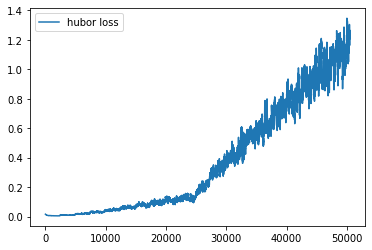

In [11]:
import matplotlib.pyplot as plt
plt.plot((np.convolve(losses, np.ones(100), 'valid') / 100), label='hubor loss')
plt.legend()
plt.show()

In [12]:
agent.QNet.eval()
environment = Environment()

for test in range(3):
    print("NEW TEST")
    while True:

        #observation
        state = environment.get_state()
        action = get_action(agent.QNet, state, epsilon=0)
        state_new, reward, terminated = environment.take_action(action)

        print("State: {}, Action: {}, Reward: {}, New State: {}, Cummulative Reward: {}\n".format(state[0], action, reward, state_new, cummulative_reward))
        #break when episode is complete
        if terminated:
            break

NEW TEST
State: 0.3190060254095124, Action: 0, Reward: 0.3190060254095124, New State: 0.3817720048257665, Cummulative Reward: 22.707411602003788

State: 0.3817720048257665, Action: 0, Reward: 0.3817720048257665, New State: 0.2858712841150109, Cummulative Reward: 22.707411602003788

State: 0.2858712841150109, Action: 0, Reward: 0.2858712841150109, New State: 0.3153212369870291, Cummulative Reward: 22.707411602003788

State: 0.3153212369870291, Action: 0, Reward: 0.3153212369870291, New State: 0.2188459153645006, Cummulative Reward: 22.707411602003788

State: 0.2188459153645006, Action: 0, Reward: 0.2188459153645006, New State: 0.2611091842247756, Cummulative Reward: 22.707411602003788

State: 0.2611091842247756, Action: 0, Reward: 0.2611091842247756, New State: 0.2871951671215816, Cummulative Reward: 22.707411602003788

State: 0.2871951671215816, Action: 0, Reward: 0.2871951671215816, New State: 0.2731214983809333, Cummulative Reward: 22.707411602003788

State: 0.2731214983809333, Actio

IndexError: index 137 is out of bounds for axis 0 with size 137

In [ ]:
plt.scatter(x=np.arange(0,1,0.01), y=[agent.QNet(torch.tensor([x]).float())[0].item() for x in np.arange(0,1,0.01)], label='hold')
plt.scatter(x=np.arange(0,1,0.01), y=[agent.QNet(torch.tensor([x]).float())[1].item() for x in np.arange(0,1,0.01)], label='repair')
plt.xlabel('health indicator', fontsize=18)
plt.ylabel('expected reward', fontsize=16)
plt.legend()

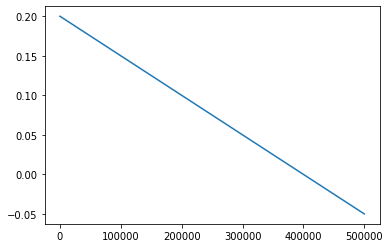

In [20]:
import matplotlib.pyplot as plt
plt.plot([0.2-(5e-7*x) for x in range(500000)])
plt.show()

In [34]:
from datetime import date, time

In [35]:
date.today().strftime("%m/%d/%y")

'04/07/22'